In [1]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
import scipy
from scipy import stats
#import matplotlib.colors as mcolorsxx

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
import databuilder.data_loader as data_loader
from trainer.trainer import Trainer
from model.build_model import TorchModel
from base.base_model import BaseModel
from utils import utils
from shash.shash_torch import Shash
# import databuilder.nino_indices as nino_indices # CAUSES CELL TO HANG

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.26.4
xarray version = 2024.2.0
pytorch version = 2.1.2.post2


### Extract PRECT anomalies time series over Seattle Metro Area (TARGET)

In [3]:
config = utils.get_config("exp006")
seed = config["seed_list"][0]

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
imp.reload(utils)
imp.reload(filemethods)
imp.reload(data_generator)

# data = ClimateData(
#     config["databuilder"], 
#     expname = config["expname"],
#     seed=seed,
#     data_dir = config["data_dir"], 
#     figure_dir=config["figure_dir"],
#     target_only = True, 
#     fetch=False,
#     verbose=False
# )

<module 'databuilder.data_generator' from '/Users/C830793391/Documents/Research/E3SM/databuilder/data_generator.py'>

In [67]:
# d_train, d_val, d_test = data.fetch_data()

In [68]:
# d_train["x"][500:540]

In [69]:
# import pickle
# import gzip

# target_PRECT_savename1 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_train_SeattleRegional_PRECT_1850-2014.pkl"
# #target_PRECT_savename1 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_train_SeattleRegional_PRECT_1850-2014.pkl"
# with gzip.open(target_PRECT_savename1, "wb") as fp:
#     pickle.dump(d_train, fp)

# target_PRECT_savename2 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_val_SeattleRegional_PRECT_1850-2014.pkl"
# #target_PRECT_savename2 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_val_SeattleRegional_PRECT_1850-2014.pkl"
# with gzip.open(target_PRECT_savename2, "wb") as fp:
#     pickle.dump(d_val, fp)

# target_PRECT_savename3 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_test_SeattleRegional_PRECT_1850-2014.pkl"
# #target_PRECT_savename3 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_test_SeattleRegional_PRECT_1850-2014.pkl"
# with gzip.open(target_PRECT_savename3, "wb") as fp:
#     pickle.dump(d_test, fp)

Process + Pickle Inputs and Targets

In [70]:
# s_dict_train, s_dict_val, s_dict_test = multi_input_data_organizer(config, MJO = True, ENSO = True, other = False)

In [71]:
# s_dict_train["y"][500:540]

In [72]:
s_dict_savename1 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_train.pkl'
# with gzip.open(s_dict_savename1, "wb") as fp:
#     pickle.dump(s_dict_train, fp)

s_dict_savename2 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_val.pkl'
# with gzip.open(s_dict_savename2, "wb") as fp:
#     pickle.dump(s_dict_val, fp)

s_dict_savename3 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'
# with gzip.open(s_dict_savename3, "wb") as fp:
#     pickle.dump(s_dict_test, fp)

with gzip.open(s_dict_savename1, "rb") as obj1:
    train_dat = pickle.load(obj1)
obj1.close()

with gzip.open(s_dict_savename2, "rb") as obj2:
    val_dat = pickle.load(obj2)
obj2.close()

with gzip.open(s_dict_savename3, "rb") as obj3:
    test_dat = pickle.load(obj3)
obj3.close()

In [73]:
test_dat["y"][500:530]

array([ 0.49327993,  0.53023835,  0.76036884,  0.82201122,  0.61755086,
        0.32327671,  0.36869985, -0.51247113, -1.04501366, -1.02951334,
       -1.27004938, -1.33892359, -1.45747402, -0.89937213,  0.28071263,
        0.66966961,  0.9230287 ,  1.23507611,  1.66655046,  1.87006717,
        1.21250534,  0.06628804, -0.61174413, -1.20732306, -1.41603124,
       -1.55949909, -1.62077655, -1.67544547, -1.76829819, -1.82638123])

In [74]:
print(np.isnan(train_dat["x"][121:-32]).any())
print(np.isnan(val_dat["x"][121:-32]).any())
print(np.isnan(test_dat["x"][121:-32]).any())

print(np.isnan(train_dat["y"][121:-32]).any())
print(np.isnan(val_dat["y"][121:-32]).any())
print(np.isnan(test_dat["y"][121:-32]).any())

False
False
False
False
False
False


Retrieve Data: 


In [5]:
# Setup the Data
front_cutoff = config["databuilder"]["front_cutoff"] # remove front nans : 74 ENSO - two front nans before daily interpolation = 60 days, daily interpolation takes 1/2 the original time step = 15 days TOTAL = ~75
back_cutoff = config["databuilder"]["back_cutoff"]  # remove back nans 

trainset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_train.pkl", front_cutoff, back_cutoff)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_val.pkl", front_cutoff, back_cutoff)
testset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_test.pkl", front_cutoff, back_cutoff)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=True,
    drop_last=False,
)

val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=False,
    drop_last=False,
)

X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)


Model Setup

In [11]:
# Setup the Model
model = TorchModel(
    config=config["arch"],
    target_mean=trainset.target.mean(axis=0),
    target_std=trainset.target.std(axis=0),
)
model.freeze_layers(freeze_id="tau")
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
criterion = getattr(module_loss, config["criterion"])()
metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

# Build the trainer
device = utils.prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data_loader=train_loader,
    validation_data_loader=val_loader,
    device=device,
    config=config,
)

torch.backends.mps is available
tensor([1.], device='mps:0')


In [12]:
# # Visualize the model
torchinfo.summary(
    model,
    [   trainset.input[: config["data_loader"]["batch_size"]].shape ],
    verbose=1,
    col_names=("input_size", "output_size", "num_params"),
)

# # Train the Model
# model.to(device)
# trainer.fit()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorchModel                               [64, 3]                   [64, 4]                   62
├─Linear: 1-1                            [64, 3]                   [64, 6]                   24
├─Linear: 1-2                            [64, 6]                   [64, 4]                   28
Total params: 114
Trainable params: 109
Non-trainable params: 5
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorchModel                               [64, 3]                   [64, 4]                   62
├─Linear: 1-1                            [64, 3]                   [64, 6]                   24
├─Linear: 1-2                            [64, 6]                   [64, 4]                   28
Total params: 114
Trainable params: 109
Non-trainable params: 5
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [86]:
# Save the Model
# path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_v5.pth'
# torch.save(model.state_dict(), path)

In [13]:
# Load the Model
path = '/Users/C830793391/Documents/Research/E3SM/saved/models/exp006_v5.pth'
model = TorchModel(config=config["arch"])
model.load_state_dict(torch.load(path))
model.eval()

TorchModel(
  (layer1): Linear(in_features=3, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=6, bias=True)
  (final): Linear(in_features=6, out_features=4, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (output_mu): Linear(in_features=4, out_features=1, bias=True)
  (output_sigma): Linear(in_features=4, out_features=1, bias=True)
  (output_gamma): Linear(in_features=4, out_features=1, bias=True)
  (output_tau): Linear(in_features=4, out_features=1, bias=True)
)

dict_keys(['epoch', 'loss', 'val_loss', 'custom_mae', 'iqr_capture', 'sign_test', 'val_custom_mae', 'val_iqr_capture', 'val_sign_test'])


TypeError: '>' not supported between instances of 'float' and 'NoneType'

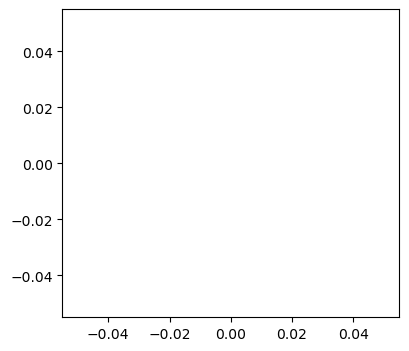

In [14]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
       x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.show()

Plot Predictions Against Climatology: 

In [89]:
with torch.inference_mode():
    print(device)
    output = model.predict(dataset=testset, batch_size=128, device=device) # The output is the batched SHASH distribution parameters
output[:20]

mps


array([[-1.1354177 ,  1.8561523 ,  0.45046163,  1.        ],
       [-1.1316385 ,  1.8608006 ,  0.4491172 ,  1.        ],
       [-1.1231924 ,  1.8699787 ,  0.44643763,  1.        ],
       [-1.1211529 ,  1.8781455 ,  0.4461066 ,  1.        ],
       [-1.125363  ,  1.8791405 ,  0.44745356,  1.        ],
       [-1.1314887 ,  1.8777425 ,  0.449296  ,  1.        ],
       [-1.1375531 ,  1.8745134 ,  0.45093238,  1.        ],
       [-1.1394829 ,  1.8728485 ,  0.45114082,  1.        ],
       [-1.137894  ,  1.8733621 ,  0.450219  ,  1.        ],
       [-1.1364456 ,  1.8742106 ,  0.44938433,  1.        ],
       [-1.1347457 ,  1.8761008 ,  0.44855717,  1.        ],
       [-1.1341448 ,  1.878347  ,  0.44818622,  1.        ],
       [-1.1344492 ,  1.8769192 ,  0.44779608,  1.        ],
       [-1.1346532 ,  1.8707085 ,  0.44688994,  1.        ],
       [-1.1309971 ,  1.8680179 ,  0.44485602,  1.        ],
       [-1.1302782 ,  1.8675587 ,  0.4441702 ,  1.        ],
       [-1.1439059 ,  1.

In [90]:
# # Save Model Outputs
# model_output_pred = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_pred_testset.pkl'
# with gzip.open(model_output_pred, "wb") as fp:
#     pickle.dump(output, fp)

In [7]:
# Open Model Outputs
model_output_pred = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_pred_testset.pkl'
with gzip.open(model_output_pred, "rb") as obj1:
    output = pickle.load(obj1)

(1800,)
Climatologial Mean = 0.00018667661056060916


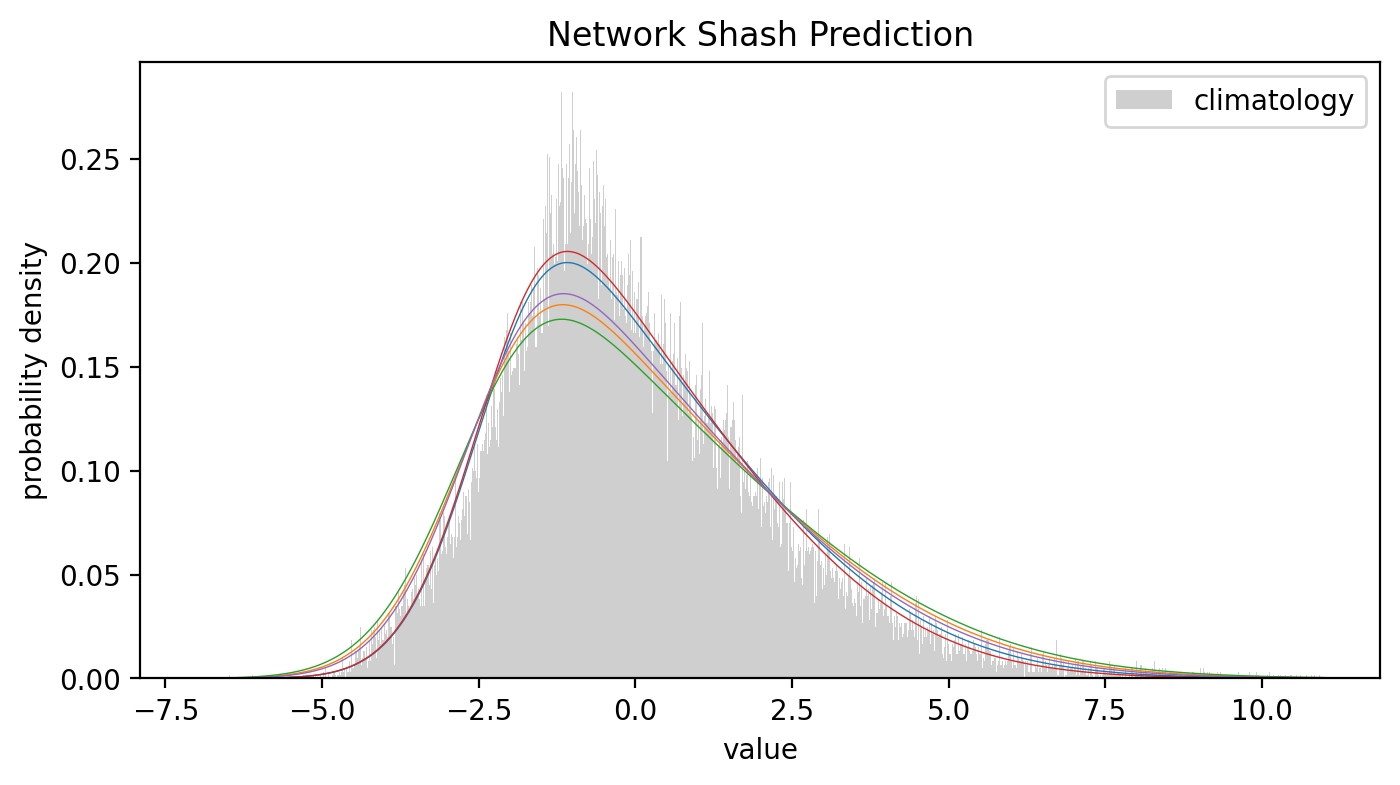

(1800, 60058)


In [40]:
from databuilder.climatology import deriveclimatology

samples = [18213, 290, 6090, 17, 1998]

#samples = np.linspace(1, 59000, 50).astype(int)

x = np.arange(-7, 11, 0.01)
print(x.shape)
cfile = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'

p = deriveclimatology(output, cfile, samples, x, testset)
print(p.shape)

## CRPS - Compare Distributions against Target / Climatology  ------------------------------

In [9]:
# Prepare Model and Target Data

# Open Model Outputs
model_output_pred = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_pred_testset.pkl'
with gzip.open(model_output_pred, "rb") as obj1:
    output = pickle.load(obj1)

# Open Target Data (test set)
target_file = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'
with gzip.open(target_file, "rb") as obj1:
    test_target = pickle.load(obj1)

test_target = test_target["y"][front_cutoff : -back_cutoff]

# SHORTEN SAMPLES FOR SPEED: 
# output = output[30000:40000, :]
# test_target = test_target[30000:40000]

#### Proper Scoring CRPS Calculations: 
https://github.com/properscoring/properscoring/blob/master/properscoring/_crps.py

In [41]:
#PROPER SCORING CODE IMPLEMENTATION:

lowerbounds = Shash(output).cdf_NONTENSOR(output, 1e-5)
upperbounds = Shash(output).cdf_NONTENSOR(output, 1 - (1e-5))

# x = np.arange(-12, 12, 0.01)
dist = Shash(output)
p = dist.prob(x).numpy()
print(p.shape)

# pdf = p[:,0] / np.sum(p[:,0])
# cdf = np.cumsum(pdf)
# plt.plot(cdf)

crps_cdf = np.zeros([len(output[:,0]), 2])
for isample, sample in enumerate(test_target):
    pdf = p[:,isample] / np.sum(p[:,isample])
    cdf = np.cumsum(pdf)
                       

    lowerbound, upperbound = _discover_bounds(cdf, tol = 1e-5)
    crps_cdf[isample, 0] = crps_quadrature(sample, cdf, xmin = lowerbound, xmax = upperbound, tol=1e-5)
    crps_cdf[isample, 1] = isample


(1800, 60058)


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
plt.figure()
plt.plot(cdf)

In [84]:
# samples_size = 20000

# crps_lower = Shash(output[:samples_size, :]).cdf_NONTENSOR(output[:samples_size,:], test_target[:samples_size]) # area under SHASH CDF up until target value
# #print(crps_lower)

# dist = Shash(output[:samples_size, :])
# p = dist.prob(test_target[:samples_size]).numpy()

# CRPS = np.zeros(samples_size)

# for idist, distribution in enumerate(p):
#     mu = output[idist, 0]
#     sigma = output[idist,1]
#     gamma = output[idist,2]
    
#     maxP = mu + 3*sigma
#             # heaviside - (1- crps_lower) = (x_inf - x) - (1 - crps_lower) = x_delta - (1 - crps_lower)
#     crps_upper =  maxP - (1 - crps_lower[idist]) # area between heaviside function and SHASH CDF 

#     CRPS[idist] =  (crps_lower[idist] + crps_upper) ** 2

In [12]:
CRPS.mean()

array([0.08950222, 0.69951852, 0.89955111, ..., 1.38244501, 1.27244505,
       1.92244791])

### Climatology as Distribution

In [ ]:
# p_climatology = 

### Sort Data into Phases

In [24]:
# SORT DATA:

# Collect CRPS and Output Data into an array with sample indices: 


# Sort 20% Lowest CRPS AND 20% lowest standard dev: 



In [ ]:
# Using Sample Indices and exp006 Inputs, Identify MJO Phase and ENSO values

In [ ]:
# Plot Buckets of MJO Phases vs CRPS

In [ ]:
# Plot buckets of ENSO phases vs CRPS